In [1]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict, namedtuple
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

%matplotlib inline

In [2]:
!!git clone https://github.com/tensorflow/models.git
%cd models/research
!!protoc research/object_detection/protos/*.proto --python_out=.
%cd ../..
if not os.path.exists('VOCdevkit/'):
    print('Downloading dataset...')
    !!wget https://pjreddie.com/media/files/VOCtrainval_11-May-2012.tar
    !!tar -xvf VOCtrainval_11-May-2012.tar
sys.path.append('models/research')    
sys.path.append('models/research/object_detection')    
sys.path.append('models/research/slim/')    
from utils import label_map_util
from utils import visualization_utils as vis_util

/home/v_stepanov/task4/models/research
/home/v_stepanov/task4


In [3]:

# What model to download.
MODEL_NAME = 'ssd_mobilenet_v1_coco_11_06_2017'
MODEL_FILE = MODEL_NAME + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = MODEL_NAME + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('models/research/object_detection/data', 'mscoco_label_map.pbtxt')

NUM_CLASSES = 90

In [4]:
opener = urllib.request.URLopener()
opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)
tar_file = tarfile.open(MODEL_FILE)
for file in tar_file.getmembers():
  file_name = os.path.basename(file.name)
  if 'frozen_inference_graph.pb' in file_name:
    tar_file.extract(file, os.getcwd())

In [5]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

In [6]:

label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

In [7]:
def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)

In [8]:
PATH_TO_TEST_IMAGES_DIR = "VOCdevkit/VOC2012/JPEGImages"
PATH_TO_IMAGE_SETS = "VOCdevkit/VOC2012/ImageSets/Main/"

train = []
with open(os.path.join(PATH_TO_IMAGE_SETS, "train.txt")) as file:
    train = file.read().splitlines()
    
validate = []
with open(os.path.join(PATH_TO_IMAGE_SETS, "val.txt")) as file:
    validate = file.read().splitlines()
    
TRAIN_IMAGE_PATHS = [os.path.join(PATH_TO_TEST_IMAGES_DIR, "{}.jpg".format(image)) for image in train]
VALIDATE_IMAGE_PATHS = [os.path.join(PATH_TO_TEST_IMAGES_DIR, "{}.jpg".format(image)) for image in validate]

IMAGE_SIZE = (12, 8)

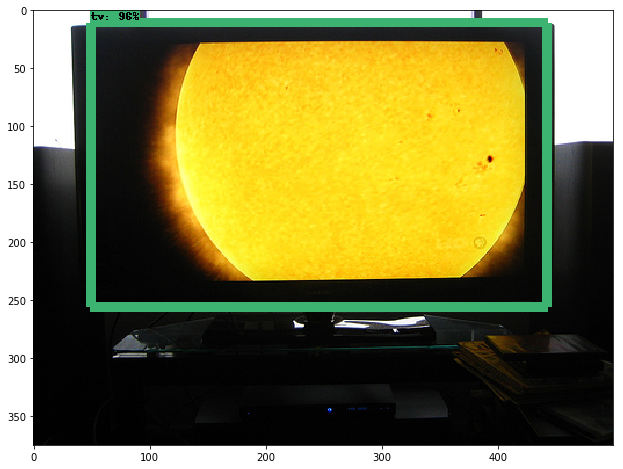

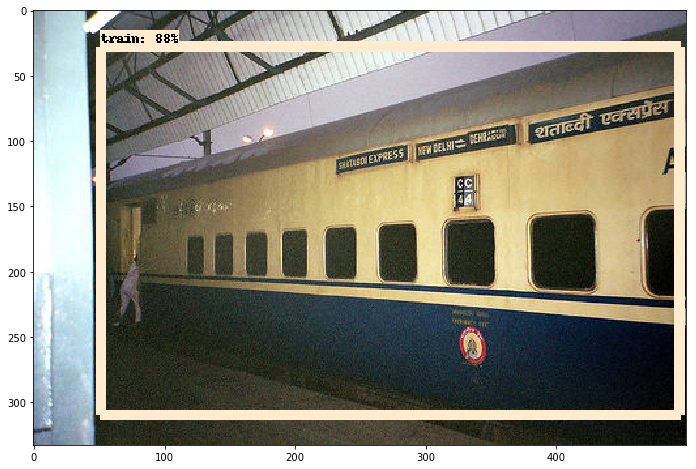

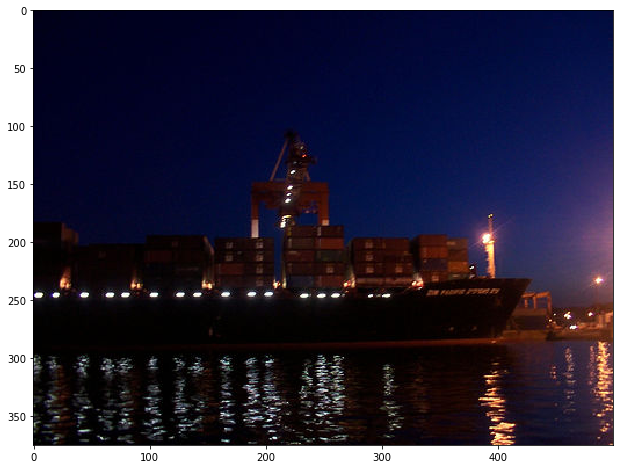

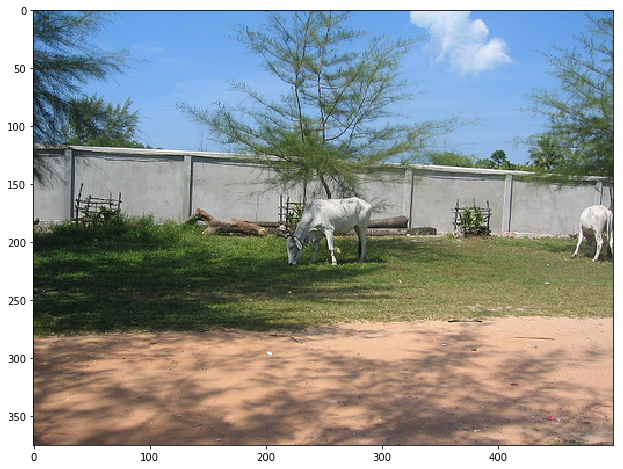

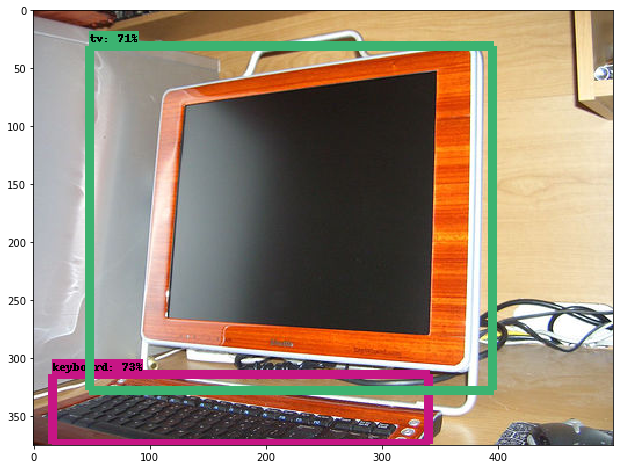

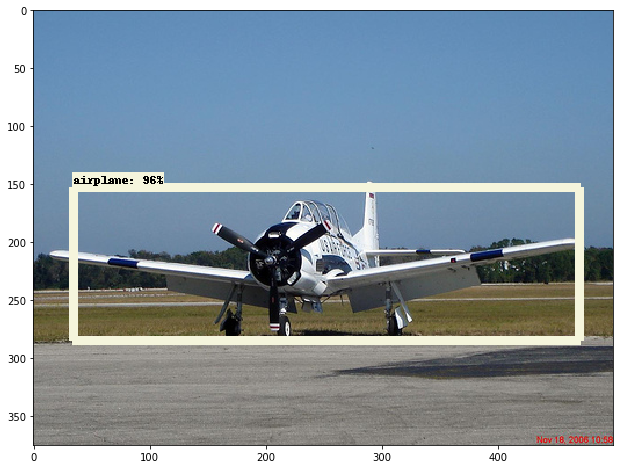

In [9]:
with detection_graph.as_default():
  with tf.Session(graph=detection_graph) as sess:
    # Definite input and output Tensors for detection_graph
    image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
    # Each box represents a part of the image where a particular object was detected.
    detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
    # Each score represent how level of confidence for each of the objects.
    # Score is shown on the result image, together with the class label.
    detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
    detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
    num_detections = detection_graph.get_tensor_by_name('num_detections:0')
    for image_path in VALIDATE_IMAGE_PATHS[:6]:
      image = Image.open(image_path)
      # the array based representation of the image will be used later in order to prepare the
      # result image with boxes and labels on it.
      image_np = load_image_into_numpy_array(image)
      # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
      image_np_expanded = np.expand_dims(image_np, axis=0)
      # Actual detection.
      (boxes, scores, classes, num) = sess.run(
          [detection_boxes, detection_scores, detection_classes, num_detections],
          feed_dict={image_tensor: image_np_expanded})
      # Visualization of the results of a detection.
  
      vis_util.visualize_boxes_and_labels_on_image_array(
          image_np,
          np.squeeze(boxes),
          np.squeeze(classes).astype(np.int32),
          np.squeeze(scores),
          category_index,
          use_normalized_coordinates=True,
          line_thickness=8)
      plt.figure(figsize=IMAGE_SIZE)
      plt.imshow(image_np)

In [10]:
from xml.etree import ElementTree
PATH_TO_ANNOTATIONS = 'VOCdevkit/VOC2012/Annotations'
annotations = [ElementTree.parse(os.path.join(PATH_TO_ANNOTATIONS, '{}.xml'.format(image))).getroot() for image in validate]


In [11]:
def get_attr(xml_node, name):
    return xml_node.find(name).text

def get_iou(box, true_box_xml):
    min_x_true = int(get_attr(true_box_xml, 'bndbox/xmin')) / 375
    min_y_true = int(get_attr(true_box_xml, 'bndbox/ymin')) / 500
    max_x_true = int(get_attr(true_box_xml, 'bndbox/xmax')) / 375
    max_y_true = int(get_attr(true_box_xml, 'bndbox/ymax')) / 500

    min_x = min(box[0], min_x_true)
    min_y = min(box[1], min_y_true)
    max_x = max(box[2], max_x_true)
    max_y = max(box[3], max_y_true)
    
    if min_x >= max_x or min_y >= max_y:
        return 0
    s_inter = (max_x - min_x) * (max_y - min_y)
    s_first = (box[2] - box[0]) * (box[3] - box[1])
    s_second = (max_x_true - min_x_true) * (max_y_true - min_y_true)
    return s_inter / (s_first + s_second - s_inter)

def get_iou_accuracy(boxes, classes, annotations):
    passed = 0
    for true_obj in annotations.findall('object'):
        for i in range(len(boxes)):
            if category_index[classes[i]]['name'] == get_attr(true_obj, 'name'):
                if get_iou(boxes[i], true_obj) > 0.5:
                    passed += 1
                
    return passed

In [12]:
with detection_graph.as_default():
  total_cnt = 0
  passed_cnt = 0
  with tf.Session(graph=detection_graph) as sess:
    # Definite input and output Tensors for detection_graph
    image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
    # Each box represents a part of the image where a particular object was detected.
    detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
    # Each score represent how level of confidence for each of the objects.
    # Score is shown on the result image, together with the class label.
    detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
    detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
    num_detections = detection_graph.get_tensor_by_name('num_detections:0')
    for image_path, annotation in zip(VALIDATE_IMAGE_PATHS[:1000], annotations):
      image = Image.open(image_path)
      # the array based representation of the image will be used later in order to prepare the
      # result image with boxes and labels on it.
      image_np = load_image_into_numpy_array(image)
      # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
      image_np_expanded = np.expand_dims(image_np, axis=0)
      # Actual detection.
      (boxes, scores, classes, num) = sess.run(
          [detection_boxes, detection_scores, detection_classes, num_detections],
          feed_dict={image_tensor: image_np_expanded})
      # Visualization of the results of a detection.
      num_of_candidates = np.count_nonzero(scores > 0.5)
      total_cnt += num_of_candidates
      passed_cnt += get_iou_accuracy(boxes.squeeze()[:num_of_candidates], classes.squeeze()[:num_of_candidates], annotation)
  print('Accuracy: {}'.format(passed_cnt / total_cnt))

Accuracy: 0.5091678420310296
